<a href="https://colab.research.google.com/github/LauraSchellekens/TM10007_-private_-group/blob/Manon_feature_selection/Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
!pip install sklearn numpy matplotlib

In [0]:
# General packages not sure anymore what I'm actually using lol
import numpy as np 
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import impute
from sklearn import datasets, linear_model
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn import feature_selection 
from sklearn import feature_selection 
from sklearn.model_selection import train_test_split

In [3]:
# Data loading functions. Uncomment the one you want to use
from adni.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


X = data.drop('label', axis=1) # All data without column 'label'
Y = data['label'] 
Y.replace(('AD', 'CN'), (1, 0), inplace=True) # convert AD and CN to 1 and 0

The number of samples: 855
The number of columns: 268


In [4]:
# split into train (70%) and test (30%) set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(598, 267) (598,)
(257, 267) (257,)


In [5]:
# Preprocessing: drop feature if too many missing values

X_train = X_train.replace(0, np.NaN)                  # replace 0 with NaN
missing_per_feature = X_train.isnull().sum()          # gives the amount of missing values (NaN) per feature
pct_null = missing_per_feature / len(X_train)         # gives percentage of missing values per feature
missing_features = pct_null[pct_null > 0.40].index    # gives features with more than 40% missing values
X_train.drop(missing_features, axis=1, inplace=True)  # remove feature if more than 40% missing values

missing_per_feature_max = max(X_train.isnull().sum()) # gives the maximum amount of missing values (NaN) per feature AFTER dropping incomplete features

print(missing_per_feature_max)
print (X_train.shape, y_train.shape)

106
(598, 261) (598,)


In [6]:
# Preprocessing:  impute missing values (fill missing)

imputer = impute.SimpleImputer(strategy='mean')     # imputer with mean 
X_train_imp = imputer.fit_transform(X_train)          # impute  
X_train_imp = pd.DataFrame(data=X_train_imp, index=[X_train.index], columns=[X_train.columns]) # turn created np.array back to pandas df

type(X_train_imp)


pandas.core.frame.DataFrame

In [7]:
# Preprocessing: scaling either standard or robust (removes median and scales data according to quantile range) 

scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)
# robust = preprocessing.RobustScaler()
# robust.fit_transform(X_train_imp)
# X_train_scaled = robust.transform(X_train_imp)

X_train_scaled = pd.DataFrame(data=X_train_scaled, index=[X_train.index], columns=[X_train.columns]) # turn created np.array back to pandas df
X_train_scaled


,hf_energy,hf_entropy,hf_kurtosis,hf_max,hf_mean,hf_median,hf_min,hf_peak,hf_quartile_range,hf_range,hf_skewness,hf_std,logf_energy_sigma1,logf_energy_sigma10,logf_energy_sigma5,logf_entropy_sigma1,logf_entropy_sigma10,logf_entropy_sigma5,logf_kurtosis_sigma1,logf_kurtosis_sigma10,logf_kurtosis_sigma5,logf_max_sigma1,logf_max_sigma10,logf_max_sigma5,logf_mean_sigma1,logf_mean_sigma10,logf_mean_sigma5,logf_median_sigma1,logf_median_sigma10,logf_median_sigma5,logf_min_sigma1,logf_min_sigma10,logf_min_sigma5,logf_peak_sigma1,logf_peak_sigma10,logf_peak_sigma5,logf_quartile_range_sigma1,logf_quartile_range_sigma10,logf_quartile_range_sigma5,logf_range_sigma1,...,tf_NGTDM_Coarseness,tf_NGTDM_Complexity,tf_NGTDM_Contrast,tf_NGTDM_Strength,"vf_Frangi_edge_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_std_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_std_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0"
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0_021_S_0337_bl_0,-0.412457,-0.638688,1.113439,0.054556,0.235839,0.190210,-0.538589,1.166152,-0.470690,0.641655,-1.496413,-0.110329,-0.202473,-0.672846,-0.971375,0.567424,0.557572,0.846912,-0.699574,-0.891864,-0.932221,0.021547,-0.501763,0.957510,1.217029,-0.063678,0.580415,0.004512,-0.116600,-0.180040,0.902120,1.237447,1.300261,-0.545619,-0.654196,-0.172625,0.762061,-0.207694,0.358870,-0.628450,...,-0.249333,-0.377551,-0.451650,-0.380402,0.797252,-1.143208,0.524920,1.362017,0.268235,-0.436910,-0.747675,3.013677,0.911959,1.408182,1.019326,1.180951,0.797252,-1.143208,0.524920,1.362017,0.268235,-0.436910,-0.747675,3.013677,0.911959,1.408182,1.019326,1.180951,-0.212451,0.222177,0.434813,-5.637006e-01,-9.065832e-01,-0.982151,-6.856925e-01,4.194762,-7.058890e-01,-0.505430,0.828281,-0.543386
0_082_S_4090_bl_0,-0.238613,-0.754035,0.298257,0.503706,0.701832,0.551381,0.973273,-0.182527,-0.464704,-0.704659,0.225992,-0.701692,-0.439292,-0.123196,0.161939,-1.361874,-1.193095,-1.972574,0.832156,0.726394,1.235727,-0.948723,-0.666642,-0.475129,-0.131526,0.097186,0.218140,-0.052891,0.257527,-0.197116,0.331584,-0.014017,-0.017069,0.943761,1.800367,1.509288,-1.564400,-1.473470,-1.975562,-0.611742,...,-0.249333,-0.867530,-0.540481,0.249321,-0.646385,-1.556820,1.974561,-0.627450,-0.643447,-0.571422,0.221490,-0.041170,-0.851010,-0.644585,1.484469,-0.685070,-0.646385,-1.556820,1.974561,-0.627450,-0.643447,-0.571422,0.221490,-0.041170,-0.851010,-0.644585,1.484469,-0.685070,-0.326517,-0.911785,-0.543560,-1.007047e+00,-5.475484e-01,-0.254982,1.594585e-01,-0.590749,-9.467271e-01,

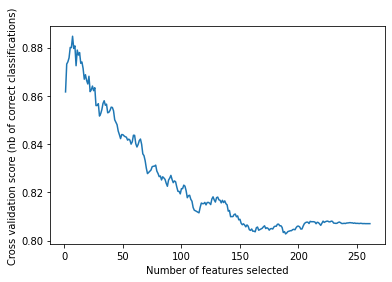

In [9]:
# Code for feature selection
'''
First determine the best amount of features
'''

# Create the RFE object and compute a cross-validated score.
svc = svm.SVC(kernel="linear")
X= X_train_scaled
y= y_train

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(X, y)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [0]:
# Code for feature selection
'''
With the amount of features desired known, find the best performing features
'''
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
 
#apply SelectKBest class to extract top ... best features
bestfeatures = SelectKBest(score_func= f_classif, k=32) # k= number of desired features
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(32,'Score'))  #print ... best features 